In [1]:
%pip install pysteps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.5/582.5 kB 2.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jsmin-3.0.1-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × Building wheel for pysteps (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [219 lines of output]
      [1/2] Cythonizing pysteps/motion/_proesmans.pyx
      [2/2] Cythonizing pysteps/motion/_vet.pyx
      running bdist_wheel
      running build
      running build_py
      creating build/lib.macosx-10.9-x86_64-cpython-311/pysteps
      copying pysteps/datasets.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps
      copying pysteps/__init__.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps
      copying pysteps/exceptions.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps
      copying pysteps/decorators.

      copying pysteps/motion/vet.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps/motion
      copying pysteps/motion/lucaskanade.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps/motion
      copying pysteps/motion/darts.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps/motion
      copying pysteps/motion/constant.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps/motion
      copying pysteps/motion/proesmans.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps/motion
      creating build/lib.macosx-10.9-x86_64-cpython-311/pysteps/nowcasts
      copying pysteps/nowcasts/steps.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps/nowcasts
      copying pysteps/nowcasts/lagrangian_probability.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps/nowcasts
      copying pysteps/nowcasts/anvil.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps/nowcasts
      copying pysteps/nowcasts/interface.py -> build/lib.macosx-10.9-x86_64-cpython-311/pysteps/nowcasts
      

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define paths
real_data_dir = "./data/real"
synthetic_data_dir = "./data/fake"
img_size = (480, 480)  # Resize images to 320x320 pixels

# Function to load images and labels from a given directory
def load_dataset(directory):
    data = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Sort class folders alphabetically
    class_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith((".jpg", ".jpeg", ".png")):
                    file_path = os.path.join(class_path, filename)
                    image = cv2.imread(file_path, cv2.IMREAD_COLOR)
                    if image is not None:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                        image = cv2.resize(image, img_size)  # Resize image
                        image = image / 255.0  # Normalize pixel values
                        data.append(image)
                        labels.append(class_map[class_name])

    return np.array(data), np.array(labels), class_map


# Load the real and synthetic datasets
real_images, real_labels, real_class_map = load_dataset(real_data_dir)
synthetic_images, synthetic_labels, synthetic_class_map = load_dataset(synthetic_data_dir)


# Verify that class mappings are consistent across both datasets
assert real_class_map == synthetic_class_map, "Class mappings do not match between real and synthetic datasets."



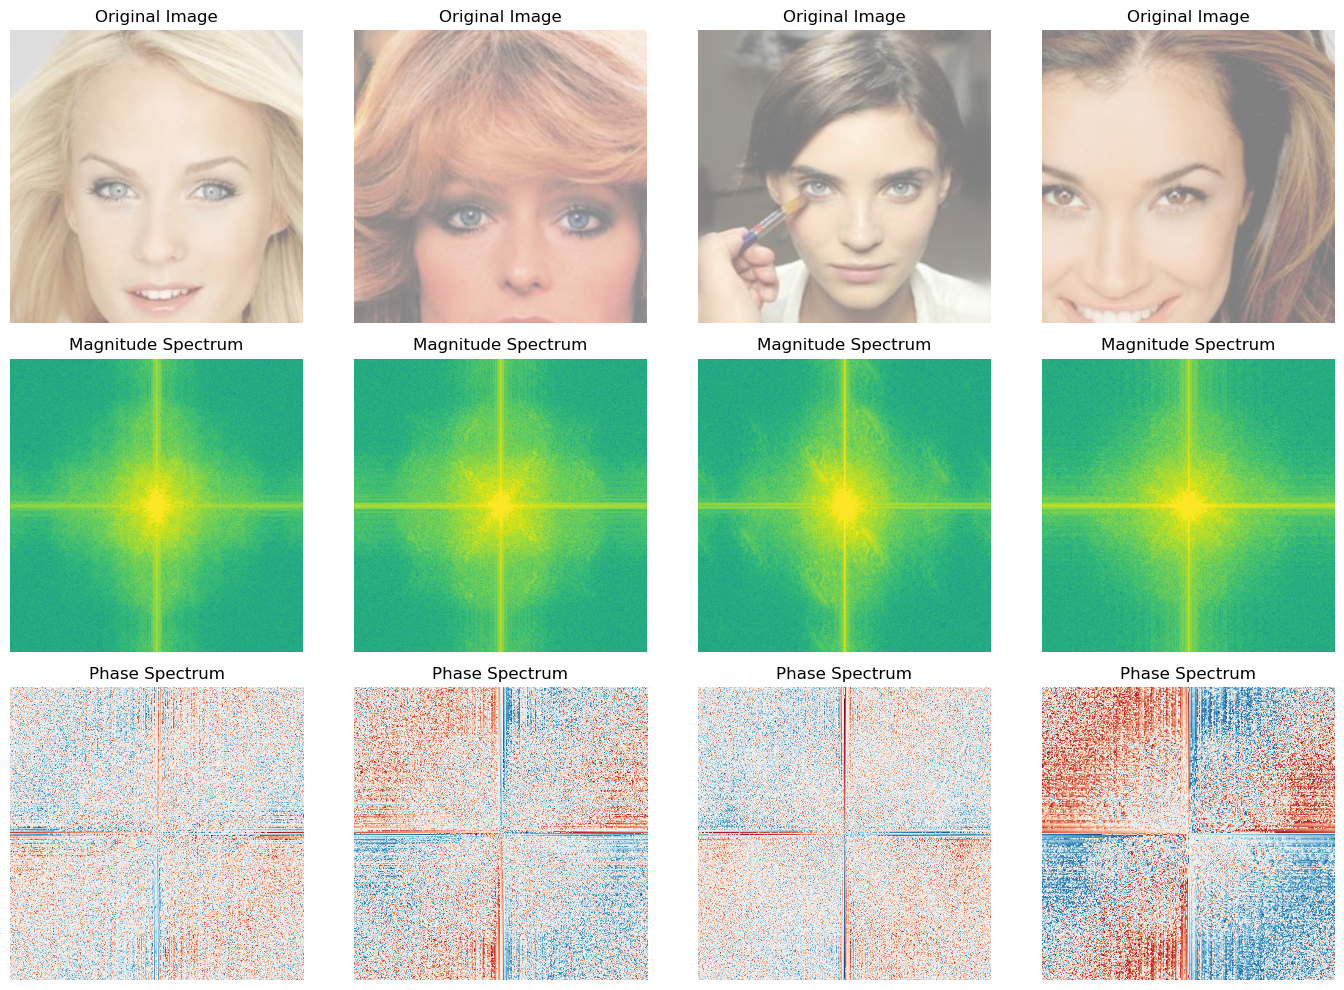

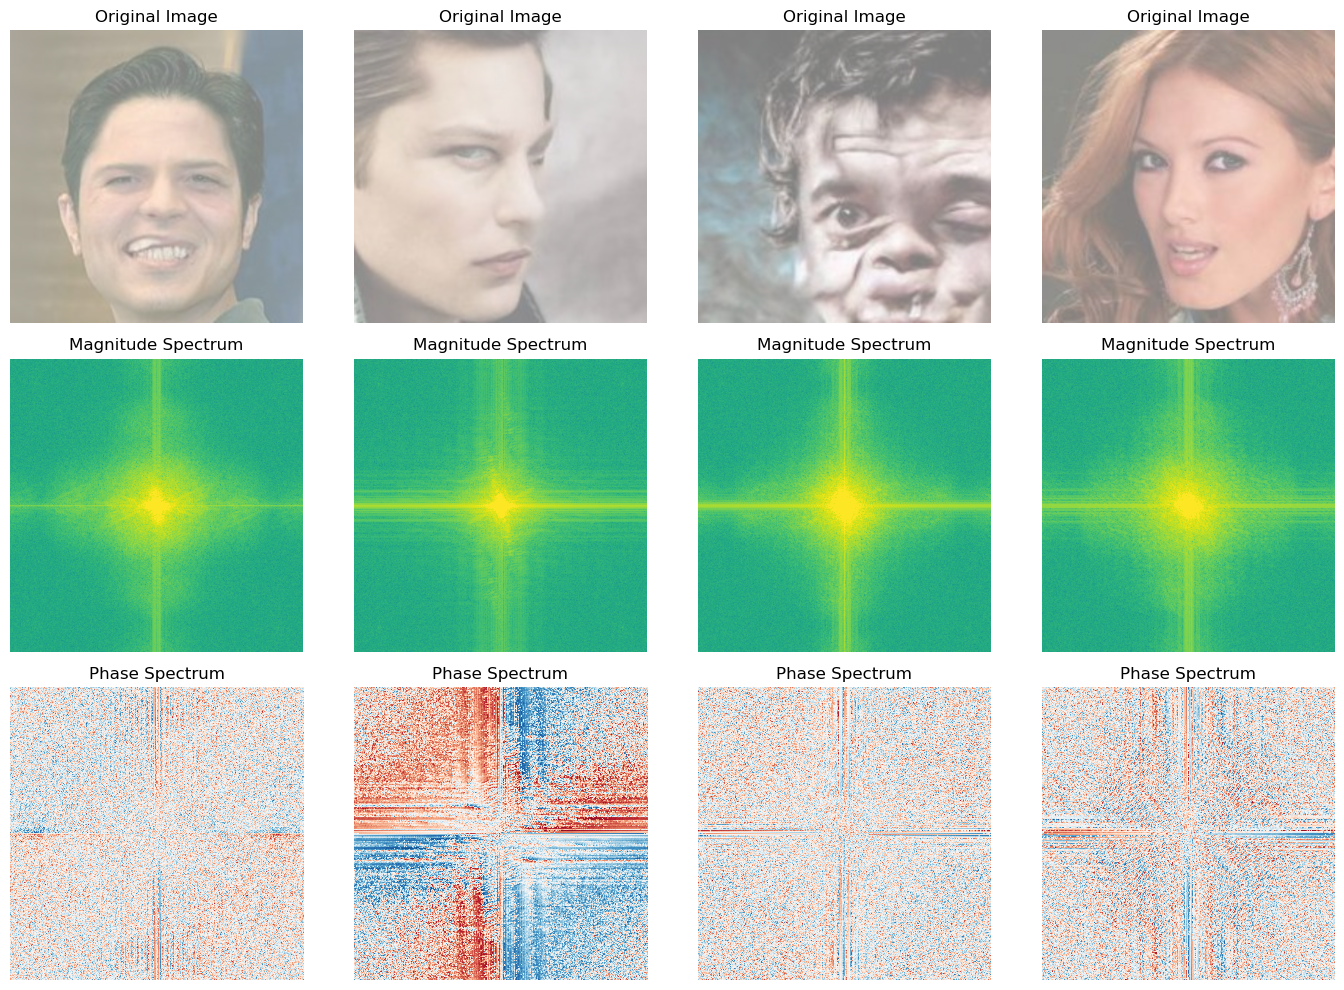

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function to perform spectral analysis and visualize the spectra
def visualize_image_spectrum(images, num_displayed_examples=4):
    plt.figure(figsize=(14, 10))

    # Display the original images
    for k in range(num_displayed_examples):
        plt.subplot(3, num_displayed_examples, k + 1)
        plt.imshow((images[k] + 1) / 2)  # Rescale to [0, 1] for visualization
        plt.axis('off')
        plt.title("Original Image")

    # Display the magnitude and phase spectra
    for k in range(num_displayed_examples):
        # Convert image to grayscale for spectral analysis
        grayscale_image = cv2.cvtColor((images[k] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Compute the 2D Fourier Transform
        spectrum = np.fft.fft2(grayscale_image)
        spectrum_shifted = np.fft.fftshift(spectrum)

        # Compute magnitude and phase
        magnitude_spectrum = np.log(np.abs(spectrum_shifted) + 1)  # Log scale for better visualization
        phase_spectrum = np.angle(spectrum_shifted)

        # Display the magnitude spectrum
        plt.subplot(3, num_displayed_examples, num_displayed_examples + k + 1)
        plt.imshow(magnitude_spectrum, cmap='viridis', vmin=-5, vmax=11)
        plt.axis('off')
        plt.title("Magnitude Spectrum")

        # Display the phase spectrum
        plt.subplot(3, num_displayed_examples, 2 * num_displayed_examples + k + 1)
        plt.imshow(phase_spectrum, cmap='RdBu', vmin=-np.pi, vmax=np.pi)
        plt.axis('off')
        plt.title("Phase Spectrum")

    plt.tight_layout()
    plt.show()

# Example usage with your real images
visualize_image_spectrum(real_images[:4])

# Example usage with your synthetic images
visualize_image_spectrum(synthetic_images[:4])

Pysteps configuration file found at: /Users/heni/anaconda3/envs/pysteps_env/lib/python3.11/site-packages/pysteps/pystepsrc



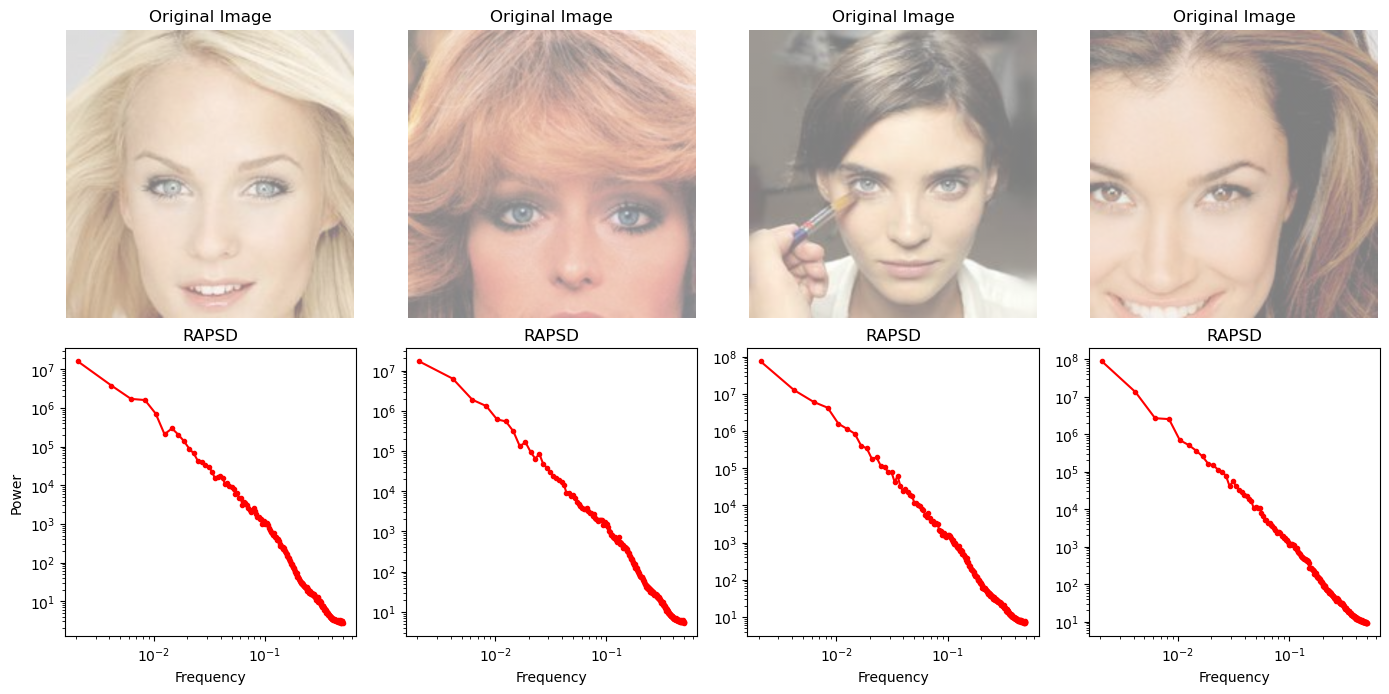

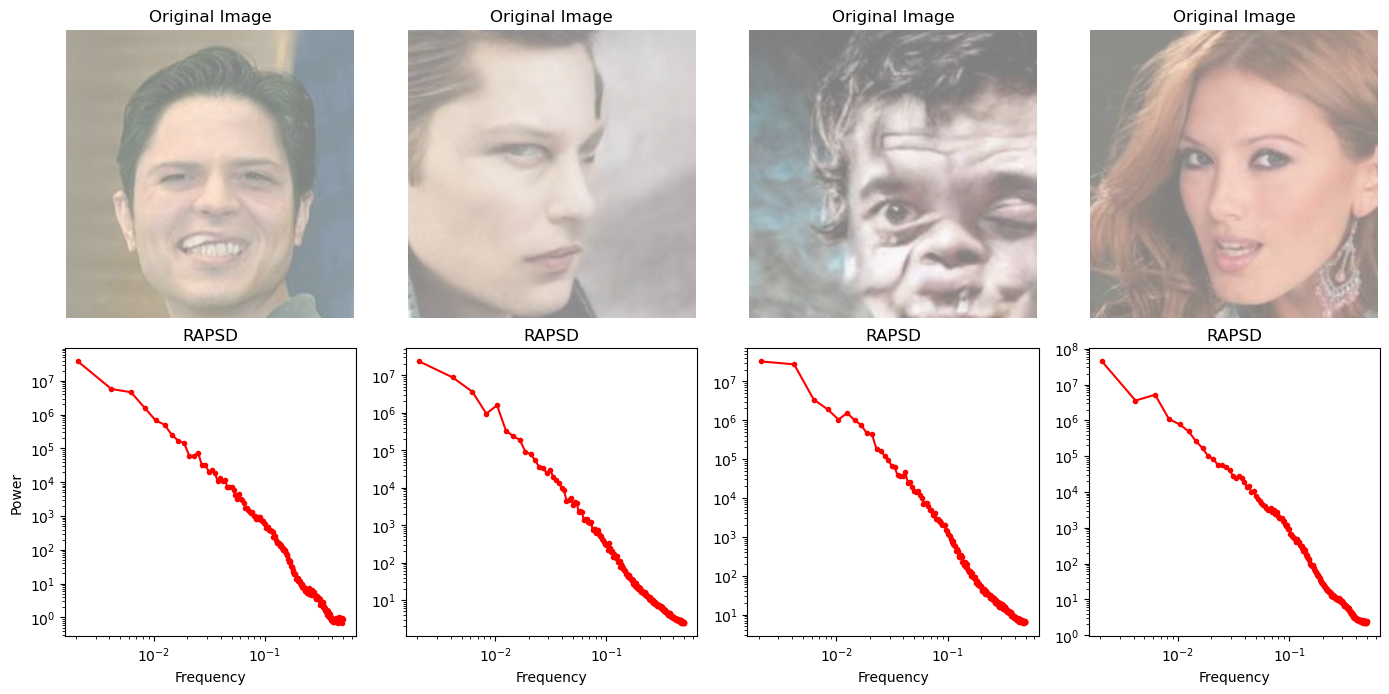

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pysteps.utils import spectral

# Function to compute and plot RAPSD for a given set of images
def plot_image_and_rapsd(images, num_displayed_examples=4):
    plt.figure(figsize=(14, 7))

    # Display the original images
    for k in range(num_displayed_examples):
        plt.subplot(2, num_displayed_examples, k + 1)
        plt.imshow((images[k] + 1) / 2)  # Rescale to [0, 1] for visualization
        plt.axis('off')
        plt.title("Original Image")

    # Display the RAPSD (log-log plot)
    for k in range(num_displayed_examples):
        # Convert image to grayscale for spectral analysis (using the green channel)
        grayscale_image = cv2.cvtColor((images[k] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Compute the RAPSD using pysteps
        rapsd, frequencies = spectral.rapsd(grayscale_image, fft_method=np.fft, return_freq=True)

        # Plot the RAPSD, ignoring the DC component (frequencies[0])
        plt.subplot(2, num_displayed_examples, num_displayed_examples + k + 1)
        plt.plot(frequencies[1:], rapsd[1:], c='red', marker='o', markersize=3)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Frequency")
        plt.ylabel("Power" if k == 0 else "")
        plt.title("RAPSD")

    plt.tight_layout()
    plt.show()

# Example usage with your real images
plot_image_and_rapsd(real_images[:4])

# Example usage with your synthetic images
plot_image_and_rapsd(synthetic_images[:4])


Processing real images...


Computing RAPSD: 100%|██████████


Processing synthetic images...


Computing RAPSD: 100%|██████████


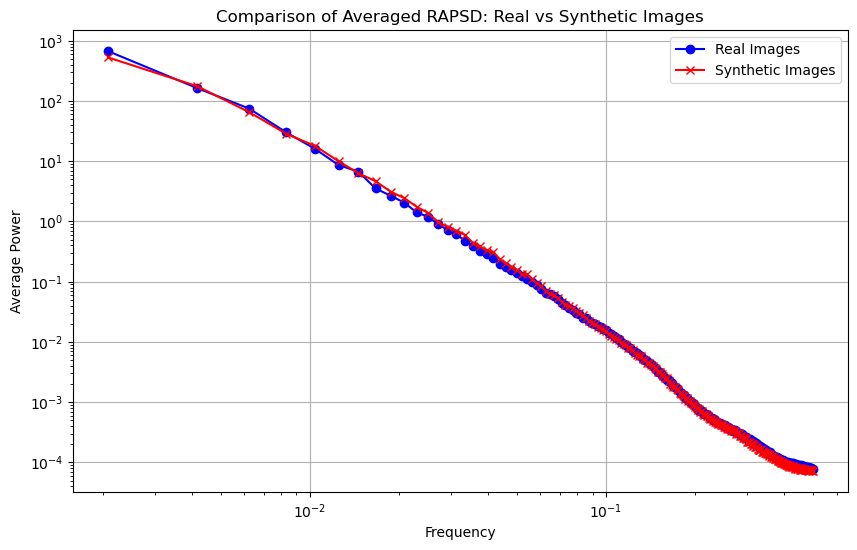

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pysteps.utils import spectral
from tqdm import tqdm

def compute_rapsd_single(image):
    # Convert the image to float32 for compatibility with OpenCV
    gray_image = cv2.cvtColor(image.astype(np.float32), cv2.COLOR_BGR2GRAY)
    # Calculate RAPSD
    rapsd, frequencies = spectral.rapsd(gray_image, fft_method=np.fft, return_freq=True)
    return rapsd, frequencies


# Function to compute and average RAPSD for a dataset
def compute_average_rapsd(images):
    all_rapsd = []
    for image in tqdm(images, desc="Computing RAPSD", bar_format="{l_bar}{bar}"):
        rapsd, frequencies = compute_rapsd_single(image)
        all_rapsd.append(rapsd)

    # Convert list to numpy array and compute the mean across all images
    all_rapsd = np.array(all_rapsd)
    mean_rapsd = np.mean(all_rapsd, axis=0)
    return mean_rapsd, frequencies

# Compute the averaged RAPSD for real and synthetic datasets
print("Processing real images...")
mean_rapsd_real, frequencies = compute_average_rapsd(real_images)

print("Processing synthetic images...")
mean_rapsd_synthetic, _ = compute_average_rapsd(synthetic_images)

# Plot the averaged RAPSD for comparison
plt.figure(figsize=(10, 6))
plt.plot(frequencies[1:], mean_rapsd_real[1:], label="Real Images", color='blue', marker='o')
plt.plot(frequencies[1:], mean_rapsd_synthetic[1:], label="Synthetic Images", color='red', marker='x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Average Power')
plt.title('Comparison of Averaged RAPSD: Real vs Synthetic Images')
plt.legend()
plt.grid()
plt.show()